# konlpy 모듈 테스트

In [8]:
import MeCab
m = MeCab.Tagger()
print(m.parse('철철철! 형 저 병쿵인데요!!!'))

철철철	MAG,*,T,철철철,*,*,*,*
!	SF,*,*,*,*,*,*,*
형	NNG,*,T,형,*,*,*,*
저	MM,~명사,F,저,*,*,*,*
병	NNG,*,T,병,*,*,*,*
쿵	NNG,*,T,쿵,*,*,*,*
인데요	VCP+EF,*,F,인데요,Inflect,VCP,EF,이/VCP/*+ᆫ데요/EF/*
!	SF,*,*,*,*,*,*,*
!!	SY,*,*,*,*,*,*,*
EOS



In [9]:
from konlpy.tag import Mecab
mecab_tokenizer = Mecab(dicpath='c:/mecab/mecab-ko-dic/').morphs
print(mecab_tokenizer('안녕하세요. 의문세 입니다.'))

['안녕', '하', '세요', '.', '의', '문세', '입니다', '.']


# 데이터 로딩 및 확인

In [36]:
import pandas as pd

train_df = pd.read_csv('./dataset/ratings_train.txt', sep='\t', encoding='utf-8')
display(train_df.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [37]:
print(train_df.shape)

(150000, 3)


In [38]:
test_df = pd.read_csv('./dataset/ratings_test.txt', sep='\t', encoding='utf-8')
print(test_df.shape)
display(test_df.head())

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [39]:
# 학습 데이터의 긍정/부정 비율 확인
print(train_df['label'].value_counts())

label
0    75173
1    74827
Name: count, dtype: int64


In [40]:
# 결측치 확인
print(train_df.isna().sum())

id          0
document    5
label       0
dtype: int64


In [41]:
# 학습 데이터의 긍정/부정 비율 확인
print(test_df['label'].value_counts())

label
1    25173
0    24827
Name: count, dtype: int64


In [42]:
# 결측치 확인
print(test_df.isna().sum())

id          0
document    3
label       0
dtype: int64


# 데이터 전처리

## 결측치 처리

In [43]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## id 컬럼 삭제

In [44]:
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

# konlpy, Mecab을 이용한 단어 토큰화

In [45]:
from konlpy.tag import Mecab

mecab = Mecab(dicpath='c:/mecab/mecab-ko-dic/')
tokens = [mecab.morphs(text) for text in train_df['document']]
tokens = list(map(lambda x: ' '.join(x), tokens))  # 단어 단위로 token된 것들을 공백으로 묶어 문장 만들어 리스트로 변환
print(tokens[:5])

['아 더 빙 . . 진짜 짜증 나 네요 목소리', '흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '너무 재 밓었다그래서보는것을추천한다', '교도소 이야기 구먼 . . 솔직히 재미 는 없 다 . . 평점 조정', '사이몬페그 의 익살 스런 연기 가 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 커스틴 던스트 가 너무나 도 이뻐 보였 다']


# KNU 한글 감성어 사전 로딩 

In [46]:
import json
import pandas as pd

with open('./dataset/SentiWord_info.json', encoding='utf-8', mode='r') as f:
    sentiword_info = json.load(f)
sentiword_df = pd.DataFrame(sentiword_info)
print(sentiword_df.shape)
display(sentiword_df.sample(5))

(14843, 3)


,word,word_root,polarity
13171,판단력을 잃다,판단력 잃,-1
10943,자주 사용되다,자주 사용,1
5241,반드럽다,반드럽,2
8406,아쉬워하는,아쉬워하,-1
2066,꺼리는 마음으로,꺼리 마음,-2


In [47]:
print(sentiword_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14843 entries, 0 to 14842
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       14843 non-null  object
 1   word_root  14843 non-null  object
 2   polarity   14843 non-null  object
dtypes: object(3)
memory usage: 348.0+ KB
None


In [48]:
sentiword_df['polarity'] = sentiword_df['polarity'].astype(int)

In [49]:
print('감성 지수 최대값:', sentiword_df['polarity'].max())
print('감성 지수 최소값:', sentiword_df['polarity'].min())
print('감성 지수 평균값:', sentiword_df['polarity'].mean())

감성 지수 최대값: 2
감성 지수 최소값: -2
감성 지수 평균값: -0.48258438321094116


In [50]:
print(sentiword_df['polarity'].value_counts())

polarity
-1    5029
-2    4797
 2    2597
 1    2266
 0     154
Name: count, dtype: int64


# 토큰화된 문장과 감성 사전 비교를 통한 감성 지수 산출

In [52]:
sentiment_score = pd.DataFrame(columns=['review', 'sentiment_score'])
idx = 0
for review in tokens:
    senti_score = 0
    for i in range(len(sentiword_df)):
        if sentiword_df['word'][i] in review:
            senti_score += sentiword_df['polarity'][i]
    sentiment_score.loc[idx] = [review, senti_score]
    idx += 1

KeyboardInterrupt: 

# 리뷰 감성 값 DataFrame 저장

In [53]:
import joblib
joblib.dump(sentiment_score, './sentiment_score.pkl')

['./sentiment_score.pkl']

In [60]:
import joblib
senti_score = joblib.load('./sentiment_score.pkl')

In [61]:
display(senti_score.head())
print(senti_score.shape)

,review,sentiment_score
0,아 더 빙 . . 진짜 짜증 나 네요 목소리,-2
1,흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나,-2
2,너무 재 밓었다그래서보는것을추천한다,-1
3,교도소 이야기 구먼 . . 솔직히 재미 는 없 다 . . 평점 조정,3
4,사이몬페그 의 익살 스런 연기 가 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 ...,-2


(149995, 2)


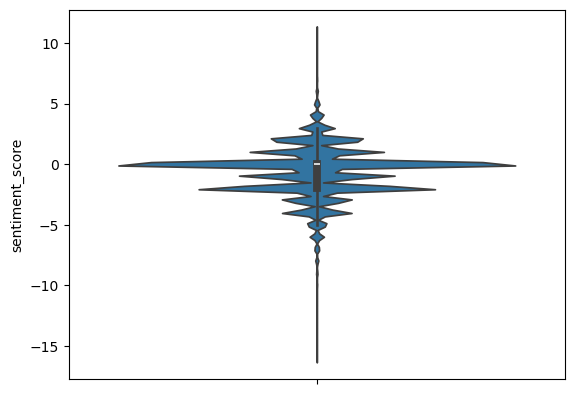

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(data=senti_score, y='sentiment_score')
plt.show()

# 감성 값 긍/부정 레이블 값으로 치환
- 감성 값이 임계치 이상인 경우는 긍정으로, 미만인 경우에는 부정의 값을 갖는 label로 치환

In [64]:
senti_score['label'] = senti_score['sentiment_score'].map(lambda x: 1 if x >= 0 else 0)

In [65]:
print(senti_score['label'].value_counts())

label
1    84501
0    65494
Name: count, dtype: int64


# 모델 성능 평가

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_target = train_df['label']
y_hat = senti_score['label']
cm = confusion_matrix(y_target, y_hat)
print(cm)
print(f'정확도:{accuracy_score(y_target, y_hat):.3f}')

[[38589 36581]
 [26905 47920]]
정확도:0.577


# 추가 분석 사항
- 한글을 제외한 다른 문자는 제거 (정규 표현식 사용 'ㄱ-ㅎ') -> 제거 결과 아무런 값도 남지 않은 레코드 확인 -> 해당 레코드 삭제
- 불용어 제거: 한글 불용어 사전은 별도로 구성 필요